### Data Dogs Group Project
#### Inseo Baek, Steph Law, Jenny Kim

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split # Helping you divide your datasets to train/test(validation)

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score


%matplotlib inline
fg_width = 20
fg_height = 10
plt.figure(figsize=(fg_width, fg_height))

## Data Preparation and Pre-prediction Analysis

In [2]:
# Read customer churn data into a pandas DataFrame
customer_churn_data = pd.read_csv("../datasets/customer_churn.csv")
customer_churn_data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


### Initial Observations
- 3333 datasets in total
- People spend about 100-120 mins on average during day, evening and night calls
- Area Code, State or Phone doesn't seem that important vis-à-vis customer churn
- Customer service calls might be important as people usually call more when they have complaints
- International calls are the most expensive, than day > evening > night in the following order

In [3]:
customer_churn_data.describe()

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [4]:
customer_churn_data.describe(include=['O'])

,State,Phone,Int'l Plan,VMail Plan,Churn?
count,3333,3333,3333,3333,3333
unique,51,3333,2,2,2
top,WV,421-6694,no,no,False.
freq,106,1,3010,2411,2850


In [5]:
# Eliminate columns that do not affect the class
list_of_col_to_drop = ['State','Area Code', 'Phone']
customer_churn_data.drop(list_of_col_to_drop, axis=1, inplace=True)

In [6]:
# Replace categorical data to be numerical, so that it can be used for predictive modelling
customer_churn_data["Churn?"].replace({'True.': 1,'False.':0}, inplace=True)
customer_churn_data["Int'l Plan"].replace({'yes': 1,'no':0}, inplace=True)
customer_churn_data["VMail Plan"].replace({'yes': 1,'no':0}, inplace=True)

In [7]:
# Add new columns that calculate total mins, charge, calls 
customer_churn_data['Total Mins'] = customer_churn_data['Day Mins'] + customer_churn_data['Eve Mins'] + customer_churn_data['Night Mins']
customer_churn_data['Total Charge'] = customer_churn_data['Day Charge'] + customer_churn_data['Eve Charge'] + customer_churn_data['Night Charge']
customer_churn_data['Total Calls'] = customer_churn_data['Day Calls'] + customer_churn_data['Eve Calls'] + customer_churn_data['Night Calls']

In [8]:
# Get data frame for no churn vs churn customers
churn_customers = customer_churn_data.loc[customer_churn_data['Churn?'] == 1]
no_churn_customers = customer_churn_data.loc[customer_churn_data['Churn?'] == 0]

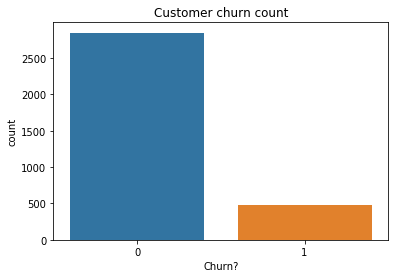

In [9]:
# See how many churns there are
sns.countplot(x="Churn?", data=customer_churn_data)
plt.title('Customer churn count')
plt.show()

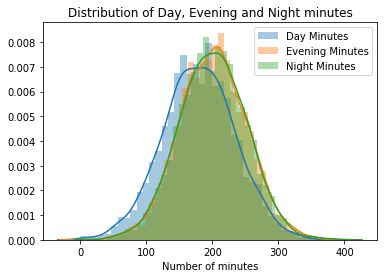

In [29]:
sns.distplot(customer_churn_data['Day Mins'], label='Day Minutes')
sns.distplot(customer_churn_data['Eve Mins'], label='Evening Minutes')
sns.distplot(customer_churn_data['Night Mins'], label='Night Minutes')

plt.title('Distribution of Day, Evening and Night minutes')
plt.xlabel('Number of minutes')
plt.legend()
plt.show()

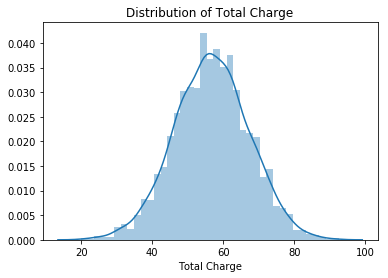

In [11]:
sns.distplot(customer_churn_data['Total Charge'])
plt.title('Distribution of Total Charge')
plt.show()

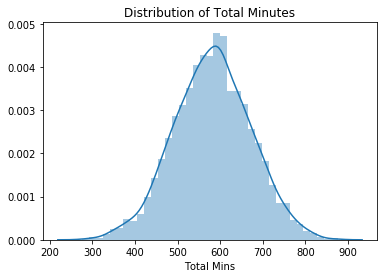

In [12]:
sns.distplot(customer_churn_data['Total Mins'])
plt.title('Distribution of Total Minutes')
plt.show()

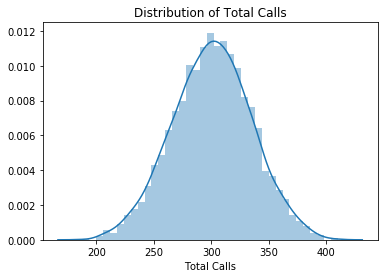

In [13]:
sns.distplot(customer_churn_data['Total Calls'])
plt.title('Distribution of Total Calls')
plt.show()

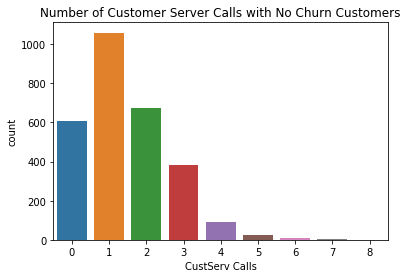

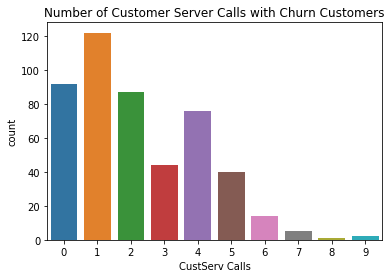

In [14]:
sns.countplot(x='CustServ Calls', data=no_churn_customers)
plt.title('Number of Customer Server Calls with No Churn Customers')
plt.show()

sns.countplot(x='CustServ Calls', data=churn_customers)
plt.title('Number of Customer Server Calls with Churn Customers')
plt.show()

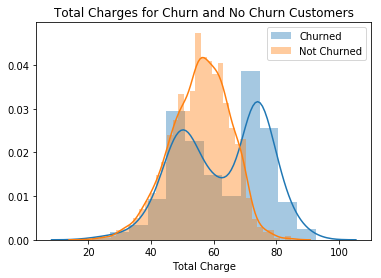

In [15]:
sns.distplot(churn_customers['Total Charge'], label='Churned')
sns.distplot(no_churn_customers['Total Charge'], label='Not Churned')
plt.title('Total Charges for Churn and No Churn Customers')
plt.legend()
plt.show()

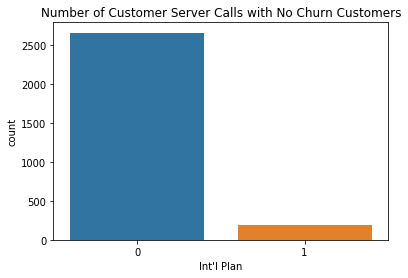

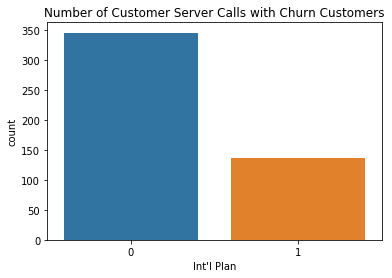

In [69]:
sns.countplot(x='Int\'l Plan', data=no_churn_customers)
plt.title('Number of Customer Server Calls with No Churn Customers')
plt.show()

sns.countplot(x='Int\'l Plan', data=churn_customers)
plt.title('Number of Customer Server Calls with Churn Customers')
plt.show()

In [16]:
# Create a new pandas data frame that takes the most relevant columns by dropping redundant data
dropped = ['Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Charge', 'Eve Calls',
          'Night Mins', 'Night Calls', 'Night Charge', 'Account Length']
correlation_pd = customer_churn_data.drop(dropped, axis=1)

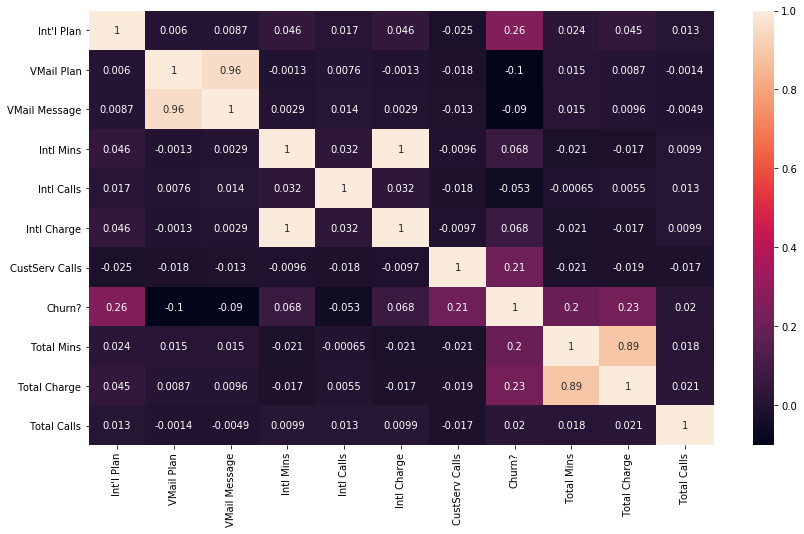

In [48]:
plt.figure(figsize=(14, 8))
# Take the relevant variables and see their correlation with class
sns.heatmap(correlation_pd.corr(), annot=True)
plt.show()

## Predictive Modelling (Classification)

In [18]:
# Prepare independent and dependent variable and split test in 0.25
X = customer_churn_data.drop('Churn?', axis=1)
y = customer_churn_data['Churn?']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [19]:
# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_predict = nb_model.predict(X_test)
nb_score = nb_model.score(X_test, y_test)

In [20]:
# Decision Tree
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
tree_predict = tree_model.predict(X_test)
tree_score = tree_model.score(X_test, y_test)

In [21]:
# Random Forest 
forest_model = RandomForestClassifier()
forest_model.fit(X_train, y_train)
forest_predict = forest_model.predict(X_test)
forest_score = forest_model.score(X_test, y_test)

In [22]:
predictions = [{'name': 'Naive Baynes', 'predict': nb_predict, 'model': nb_model },
               {'name': 'Decision Tree', 'predict': tree_predict, 'model': tree_model },
               {'name': 'Random Forest', 'predict': forest_predict, 'model': forest_model }]

def get_results(fn):
    for p in predictions:
        fn(p)

In [23]:
# Get classification report
def get_classification_report(prediction):
    report = classification_report(y_test, prediction['predict'])
    print(prediction['name'], '\n', report)

get_results(get_classification_report)

Naive Baynes 
              precision    recall  f1-score   support

          0       0.93      0.92      0.93       708
          1       0.58      0.63      0.61       126

avg / total       0.88      0.88      0.88       834

Decision Tree 
              precision    recall  f1-score   support

          0       0.97      0.97      0.97       708
          1       0.82      0.86      0.84       126

avg / total       0.95      0.95      0.95       834

Random Forest 
              precision    recall  f1-score   support

          0       0.96      0.99      0.98       708
          1       0.96      0.79      0.86       126

avg / total       0.96      0.96      0.96       834



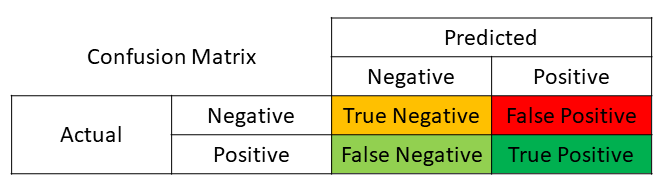

In [24]:
# Calculate confusion matrix
def get_confusion_matrix(model):
    cm = confusion_matrix(y_test, model['predict'])
    print('Confusion matrix: \n', model['name'], '\n', cm)

get_results(get_confusion_matrix)

Confusion matrix: 
 Naive Baynes 
 [[650  58]
 [ 46  80]]
Confusion matrix: 
 Decision Tree 
 [[685  23]
 [ 18 108]]
Confusion matrix: 
 Random Forest 
 [[704   4]
 [ 27  99]]


In [25]:
# Calculate Logarithmic Loss of model
scoring = 'neg_log_loss'

def get_log_loss(model):
    loss = cross_val_score(model['model'], X, y, cv=6, scoring=scoring )
    print('Cross-validated losses in 6 fold:\n', model['name'], loss)
    
get_results(get_log_loss)

Cross-validated losses in 6 fold:
 Naive Baynes [-0.49809376 -0.45029937 -0.45924449 -0.29136882 -0.44007926 -0.38739724]
Cross-validated losses in 6 fold:
 Decision Tree [-2.17420355 -1.98784325 -1.73936284 -1.86696089 -2.30258509 -1.43133668]
Cross-validated losses in 6 fold:
 Random Forest [-0.48992974 -0.48732101 -0.76925763 -0.35612072 -0.72438682 -0.39788344]


In [26]:
# Calculate R^2 score of model
def get_r2_score(model):
    score = r2_score(y_test, model['predict'])
    print('Cross-predicted accuracy: \n', model['name'], score)

get_results(get_r2_score)

Cross-predicted accuracy: 
 Naive Baynes 0.027710519235943143
Cross-predicted accuracy: 
 Decision Tree 0.6166935700834006
Cross-predicted accuracy: 
 Random Forest 0.7101829432337907


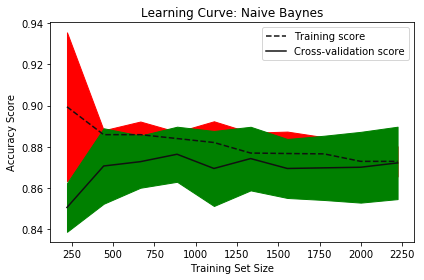

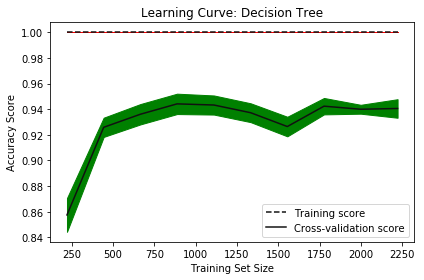

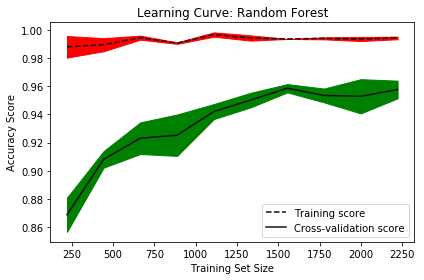

In [27]:
# Calculate learning curve of model
# http://scikit-learn.org/stable/modules/learning_curve.html
def get_learning_curve(model):
    train_sizes, train_scores, valid_scores = learning_curve(
        model['model'], X, y, train_sizes=np.linspace(0.1, 1.0, 10),
                   exploit_incremental_learning=False,
                   n_jobs=1, pre_dispatch="all", verbose=0)
    # Create means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Create means and standard deviations of test set scores
    test_mean = np.mean(valid_scores, axis=1)
    test_std = np.std(valid_scores, axis=1)

    # Draw lines
    plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

    # Draw bands
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g")

    # Create plot
    model_name = 'Learning Curve: ' + model['name']
    plt.title(model_name)
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()


get_results(get_learning_curve)